In [1]:
%%time
import matplotlib
from marss2l.utils import setup_stream_logger, get_remote_filesystem, pathjoin
from marss2l import loaders
import logging
import os

import uuid
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import PrecisionRecallDisplay, precision_score, recall_score, accuracy_score,\
    average_precision_score, confusion_matrix
from sklearn.metrics import RocCurveDisplay, roc_curve
import numpy as np
from marss2l.plot import C0, C1, C2, C3
import seaborn as sns
import json

logger = logging.getLogger(__name__)
setup_stream_logger(logger)


fs = get_remote_filesystem()
os.makedirs("figures", exist_ok=True)

Using account key
CPU times: user 9.27 s, sys: 2.96 s, total: 12.2 s
Wall time: 10.5 s


In [2]:
csv_path = "az://public/MARS-S2L/dataset_20250609/validated_images_all.csv"  # loaders.CSV_PATH_DEFAULT
dataframe_data_traintest = loaders.read_csv(csv_path,
                                            add_columns_for_analysis=True, fs=fs, 
                                            split="all", 
                                            add_case_study=True, add_loc_type=True)
dataframe_data_traintest.shape

(93581, 59)

In [3]:
from marss2l.validation_utils import load_stats_and_config
pd.options.display.float_format = "{:,.2f}".format


basefolder_experiments = "az://public/MARS-S2L/train_logs_revision/"


outs = []
ids_all = None


expload = [
          ("MARSS2L_20250326", "MARS-S2L", "preds_test_2023th100"),
          ("MARSS2L_off_20250523", "MARS-S2L (offshore)", "preds_test_2023thr100"),
          ("CH4Net_20250329","CH4Net", "preds_test_2023thr100"),
          ("MBMP","MBMP", "preds_test_2023th100")
]

config_experiments = dict()
for  train_folder, model_name, csv_file in  expload:
    output, config = load_stats_and_config(train_folder, model_name, csv_file=csv_file,
                                           basefolder_experiments=basefolder_experiments,fs=fs,
                                           logger=logger)
    if config is not None:
        config_experiments[model_name] = config
    
    ids_iter = set(output["id_loc_image"].values)
    if ids_all is None:
        ids_all = ids_iter
    else:
        ids_all = ids_all.intersection(ids_iter)
    outs.append(output)
print(f"There are {len(ids_all)} common ids")

outs = pd.concat(outs, ignore_index=True)
outs = outs[outs.id_loc_image.isin(ids_all)].copy()

outs.groupby(["model_name","target"])[["id_loc_image"]].count()

/home/gonzalo/mambaforge/envs/marss2lpy312/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-06-18 10:01:36,040 - __main__ - INFO - Loading eval results from az://public/MARS-S2L/train_logs_revision/MARSS2L_20250326/preds_test_2023th100.csv
2025-06-18 10:01:39,817 - __main__ - INFO - Loading config from az://public/MARS-S2L/train_logs_revision/MARSS2L_20250326/config_experiment.json
2025-06-18 10:01:40,370 - __main__ - INFO - Loading eval results from az://public/MARS-S2L/train_logs_revision/MARSS2L_off_20250523/preds_test_2023thr100.csv
2025-06-18 10:01:45,145 - __main__ - INFO - Loading config from az://public/MARS-S2L/train_logs_revision/MARSS2L_off_20250523/config_experiment.json
2025-06-18 10:01:45,790 - __main__ - INFO - Loading eval results from az://public/MARS-S2L/train_logs_revision/CH4Net_

There are 43529 common ids


id_loc_image
model_name          target              
CH4Net              0              41716
                    1               1813
MARS-S2L            0              41716
                    1               1813
MARS-S2L (offshore) 0              41716
                    1               1813
MBMP                0              41716
                    1               1813

In [4]:
threshold_mbmp = -.99
threshold_marss2l = 0.5
outs_merge = outs.drop(["location_name", "tile"], axis=1)
outs_same_period_with_fluxrate = pd.merge(outs_merge, dataframe_data_traintest[dataframe_data_traintest.split_name == "test_2023"], 
                                          on ="id_loc_image")
outs_same_period_with_fluxrate = outs_same_period_with_fluxrate.drop("target", axis=1) # Use isplume as GT from dataframe_data_traintest
outs_same_period_with_fluxrate["isplumenum"] = outs_same_period_with_fluxrate["isplume"].astype(int)
# outs_same_period_with_fluxrate["isplumeprednum"] = (outs_same_period_with_fluxrate["scene_pred"] > 0.5).astype(int)
outs_same_period_with_fluxrate["isplumeprednum"] = outs_same_period_with_fluxrate.apply(lambda row: row.scene_pred > threshold_mbmp if row.model_name.startswith("MBMP") else row.scene_pred > threshold_marss2l, axis=1).astype(int)
outs_same_period_with_fluxrate["scenepredcontinuous"] = outs_same_period_with_fluxrate["scene_pred"]
outs_same_period_with_fluxrate.id_loc_image.nunique()

43529

In [5]:
marss2l_onshore = outs_same_period_with_fluxrate[((outs_same_period_with_fluxrate.model_name == "MARS-S2L") & ~outs_same_period_with_fluxrate.offshore)].copy()
marss2l_onshore["model_name"] = "MARS-S2L (combined)"
marss2l_offshore = outs_same_period_with_fluxrate[((outs_same_period_with_fluxrate.model_name == "MARS-S2L (offshore)") & outs_same_period_with_fluxrate.offshore)].copy()
marss2l_offshore["model_name"] = "MARS-S2L (combined)"
outs_same_period_with_fluxrate = pd.concat([outs_same_period_with_fluxrate, marss2l_onshore, marss2l_offshore], ignore_index=True)
outs_same_period_with_fluxrate.id_loc_image.nunique()
# Rename MARS-S2L combined and drop offshore
outs_same_period_with_fluxrate = outs_same_period_with_fluxrate[~outs_same_period_with_fluxrate.model_name.isin(["MARS-S2L (offshore)", "MARS-S2L"])].copy()
outs_same_period_with_fluxrate.loc[outs_same_period_with_fluxrate.model_name == "MARS-S2L (combined)","model_name"] = "MARS-S2L"

In [6]:
from marss2l.metrics import get_scenelevel_metrics, get_pixellevel_metrics
    
mets = []
for model, dg in outs_same_period_with_fluxrate.groupby("model_name"):
    threshold = threshold_marss2l if not model.startswith("MBMP") else threshold_mbmp
    mets_iter = get_scenelevel_metrics(dg.scenepredcontinuous, dg.isplumenum, threshold=threshold,
                                       as_percentage=True)
    mets_seg = get_pixellevel_metrics(TP=dg.TP, TN=dg.TN, FP=dg.FP, FN=dg.FN,
                                     as_percentage=True)
    mets_iter.update(mets_seg)
    mets_iter.update({"nsamples": dg.shape[0],
                 "nlocs": dg.location_name.nunique(),
                 "nplumes": dg.isplumenum.sum(),
                 "nnoplume": (1-dg.isplumenum).sum(),
                 "model_name": model})
    mets.append(mets_iter)

mets = pd.DataFrame(mets).sort_values(["balanced_accuracy"], ascending=False)
overall_mets = mets[["model_name"]+[c for c in mets.columns if c != "model_name"]].copy()
overall_mets

,model_name,average_precision,precision,recall,accuracy,binary_cross_entropy,fpr,balanced_accuracy,segmentation_precision,segmentation_recall,segmentation_accuracy,segmentation_f1,segmentation_fpr,iou,nsamples,nlocs,nplumes,nnoplume
1,MARS-S2L,64.08,32.53,79.15,92.29,0.23,7.13,86.01,39.93,62.60,99.78,48.76,0.16,32.24,43529,1289,1813,41716
0,CH4Net,21.20,16.44,46.94,87.86,0.34,10.37,68.29,15.93,23.12,99.67,18.86,0.20,10.41,43529,1289,1813,41716
2,MBMP,4.22,4.74,78.87,33.11,1.50,68.88,55.00,0.26,3.21,97.84,0.49,2.00,0.24,43529,1289,1813,41716


## Figure number of images to review

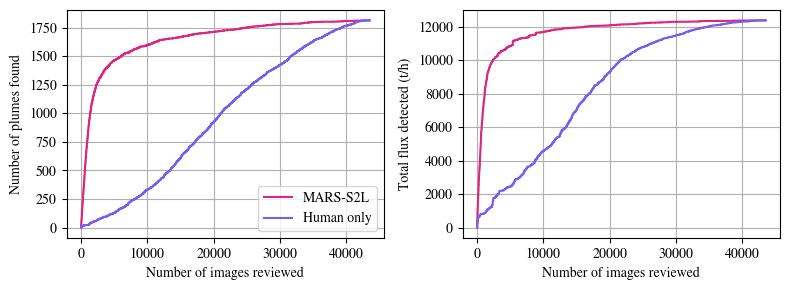

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from marss2l.plot import C0, C1, C2, C3, C4
# sns.lineplot(x,y, drawstyle='steps-pre') # post

fig, ax = plt.subplots(1, 2 , figsize=(8,3), tight_layout=True)

colors = [C2, C1, C4]


for i, model in enumerate(["MARS-S2L", "MBMP"]): # , "CH4Net"
    df_plot = outs_same_period_with_fluxrate[outs_same_period_with_fluxrate.model_name == model].sort_values("scene_pred", ascending=False).reset_index(drop=True).copy()
    df_plot["nplumes_found"] = np.cumsum(df_plot["isplume"])
    df_plot["Accumulated_flux"] = np.cumsum(df_plot["ch4_fluxrate"]) / 1_000
    df_plot["nimages"] = np.arange(len(df_plot))
    if model == "MBMP":
        model = "Human only"
    ax[0].step(df_plot["nimages"], df_plot["nplumes_found"], where="pre", label=model,c=colors[i])
    ax[1].step(df_plot["nimages"], df_plot["Accumulated_flux"], where="pre", label=model,c=colors[i])

ax[0].legend()
ax[0].set_xlabel("Number of images reviewed")
ax[0].set_ylabel("Number of plumes found")
ax[1].set_xlabel("Number of images reviewed")
ax[1].set_ylabel("Total flux detected (t/h)")
ax[0].grid()
ax[1].grid()

# ax[0].set_xscale('log')
# ax[1].set_xscale('log')

plt.savefig("figures/fig2_number_of_images_to_review.pdf")

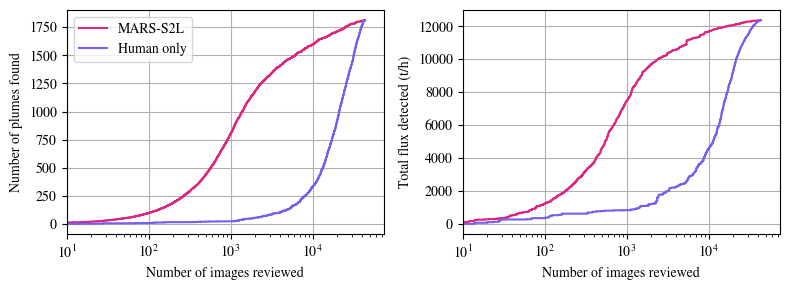

In [14]:
# sns.lineplot(x,y, drawstyle='steps-pre') # post

fig, ax = plt.subplots(1, 2 , figsize=(8,3), tight_layout=True)

colors = [C2, C1, C4]


for i, model in enumerate(["MARS-S2L", "MBMP"]): # , "CH4Net"
    df_plot = outs_same_period_with_fluxrate[outs_same_period_with_fluxrate.model_name == model].sort_values("scene_pred", ascending=False).reset_index(drop=True).copy()
    df_plot["nplumes_found"] = np.cumsum(df_plot["isplume"])
    df_plot["Accumulated_flux"] = np.cumsum(df_plot["ch4_fluxrate"]) / 1_000
    df_plot["nimages"] = np.arange(len(df_plot))
    if model == "MBMP":
        model = "Human only"
    ax[0].step(df_plot["nimages"], df_plot["nplumes_found"], where="pre", label=model,c=colors[i])
    ax[1].step(df_plot["nimages"], df_plot["Accumulated_flux"], where="pre", label=model,c=colors[i])

ax[0].legend()
ax[0].set_ylabel("Number of plumes found")
ax[1].set_ylabel("Total flux detected (t/h)")

for axi in ax:
    axi.grid()
    axi.set_xlabel("Number of images reviewed")
    axi.set_xscale('log')
    axi.set_xlim(10,None)

plt.savefig("figures/fig2_number_of_images_to_review_log.pdf")